In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 30

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [6]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-052043-var-30-lev-30/model.ckpt-3062.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-052043-var-30-lev-30/model.ckpt-3062


In [7]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [8]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [9]:
LEVEL = 30

In [10]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [11]:
np.set_printoptions(precision=3, suppress=True)

In [12]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [13]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [14]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [15]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [16]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [30]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    if light == False:
        compute_and_print_steps(sats, RandomVarDPLL)
        compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    if light == False:
        compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

 50%|█████     | 5/10 [00:00<00:00, 18.09it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 26.24it/s]


#Sats: 10; avg step: 956.40; stdev step: 533.40; avg error: 6.40; stdev error: 2.15


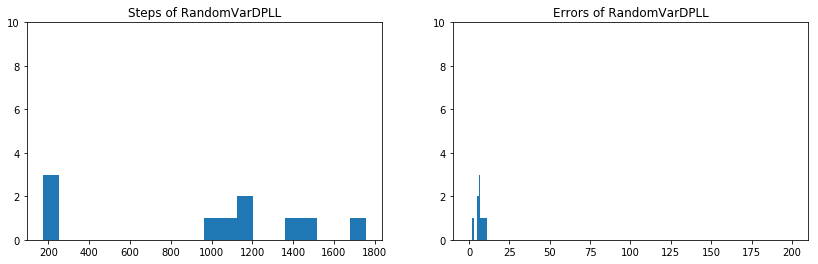

100%|██████████| 10/10 [00:00<00:00, 31.71it/s]


#Sats: 10; avg step: 752.70; stdev step: 378.12; avg error: 5.20; stdev error: 1.83


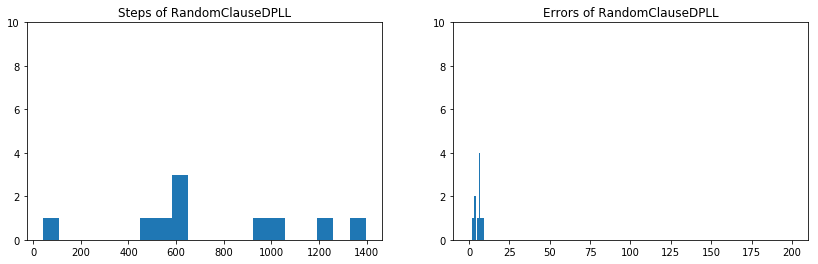

100%|██████████| 10/10 [00:18<00:00,  1.21s/it]


#Sats: 10; avg step: 97.60; stdev step: 150.89; avg error: 0.50; stdev error: 0.92


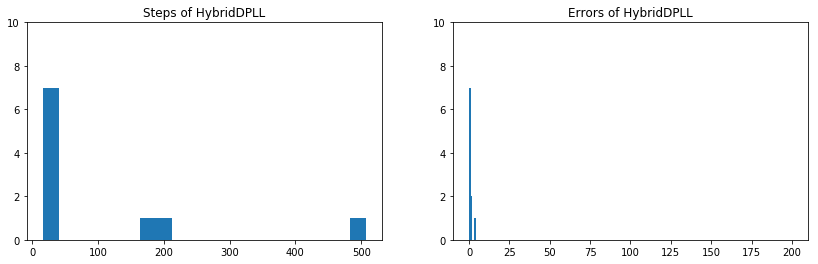

100%|██████████| 10/10 [00:32<00:00,  1.76s/it]


#Sats: 10; avg step: 138.20; stdev step: 266.17; avg error: 0.30; stdev error: 0.46


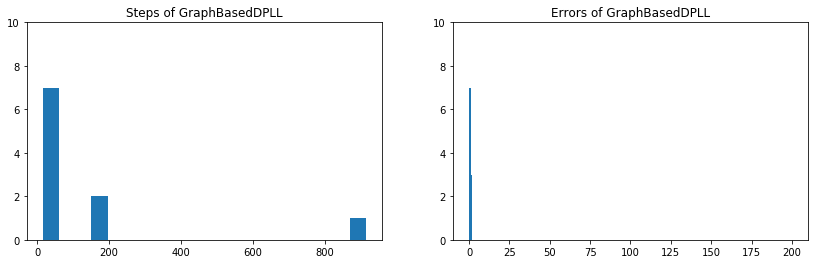

100%|██████████| 10/10 [00:00<00:00, 107.25it/s]


#Sats: 10; avg step: 147.80; stdev step: 99.29; avg error: 2.50; stdev error: 0.67


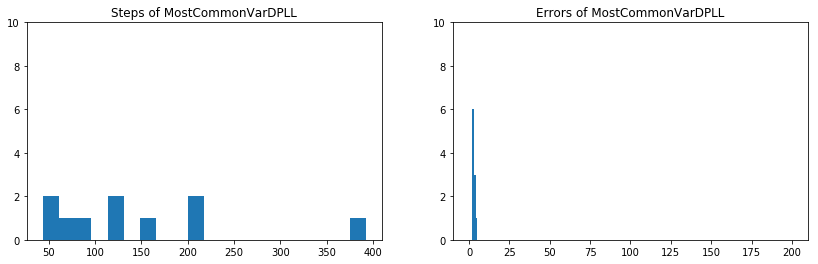

In [18]:
print_all(10, 200, 15)

100%|██████████| 10/10 [00:00<00:00, 472.04it/s]

We have generated 10 formulas
#Sats: 10; avg step: 79.10; stdev step: 50.91; avg error: 3.90; stdev error: 1.64


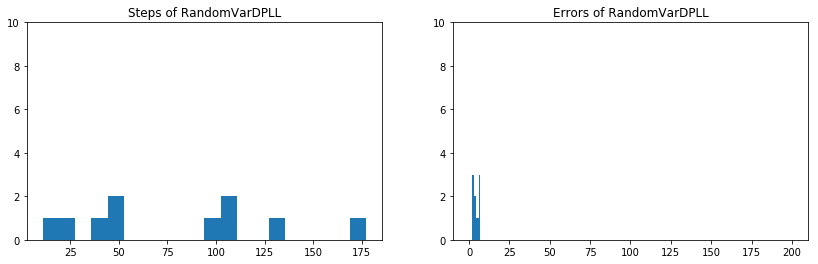

100%|██████████| 10/10 [00:00<00:00, 921.40it/s]


#Sats: 10; avg step: 29.00; stdev step: 28.12; avg error: 1.60; stdev error: 1.20


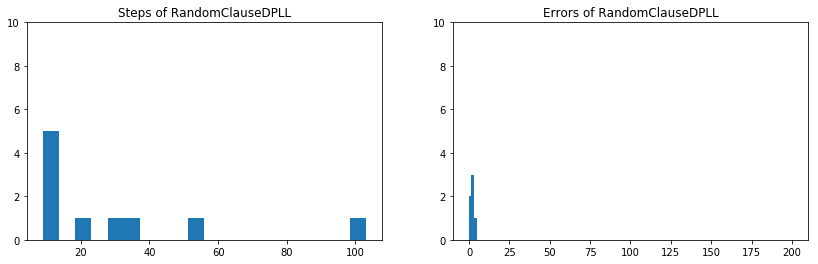

100%|██████████| 10/10 [00:04<00:00,  1.84it/s]


#Sats: 10; avg step: 21.10; stdev step: 21.66; avg error: 0.30; stdev error: 0.46


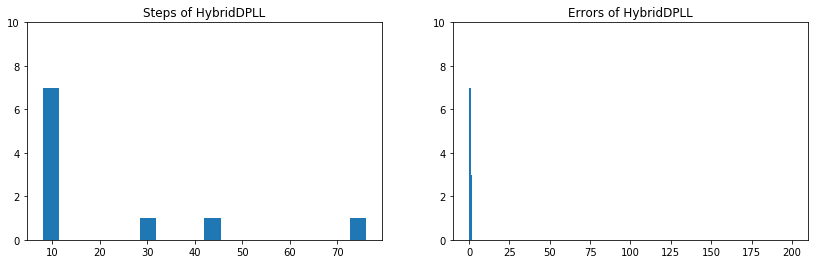

100%|██████████| 10/10 [00:04<00:00,  1.90it/s]


#Sats: 10; avg step: 21.10; stdev step: 21.66; avg error: 0.30; stdev error: 0.46


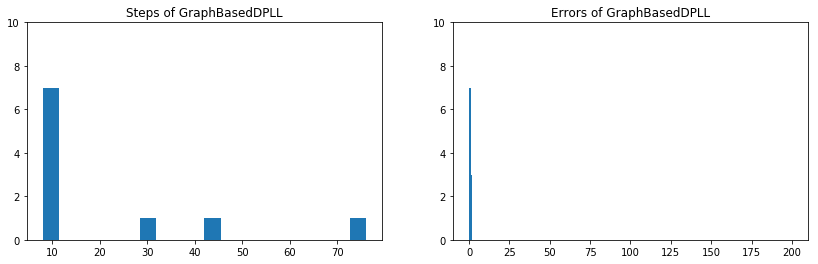

100%|██████████| 10/10 [00:00<00:00, 695.53it/s]


#Sats: 10; avg step: 35.20; stdev step: 28.77; avg error: 1.30; stdev error: 1.10


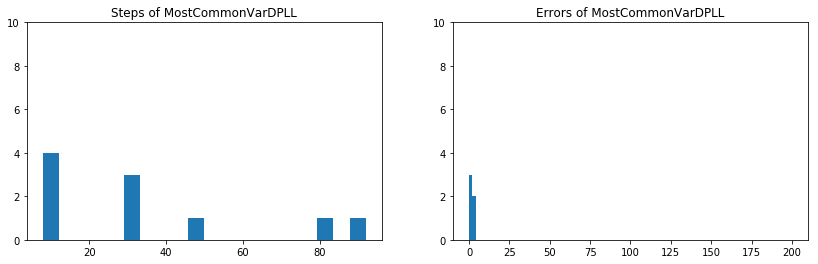

In [19]:
print_all(10, 200, 8)

100%|██████████| 10/10 [00:00<00:00, 202.91it/s]

We have generated 10 formulas
#Sats: 10; avg step: 197.20; stdev step: 111.92; avg error: 5.50; stdev error: 1.43


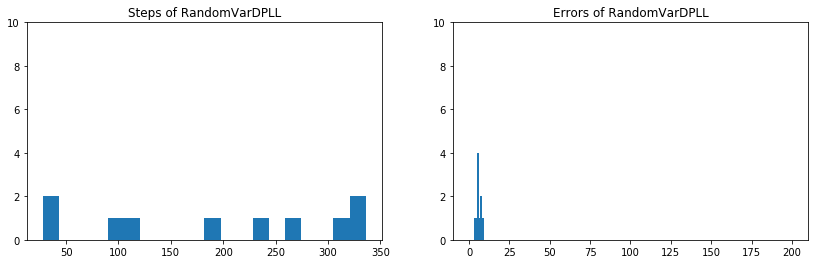

100%|██████████| 10/10 [00:00<00:00, 271.45it/s]


#Sats: 10; avg step: 115.80; stdev step: 63.98; avg error: 3.30; stdev error: 1.49


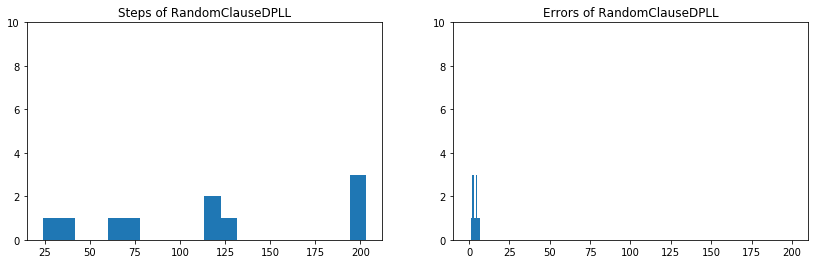

100%|██████████| 10/10 [00:07<00:00,  2.03it/s]


#Sats: 10; avg step: 44.40; stdev step: 76.13; avg error: 0.50; stdev error: 0.92


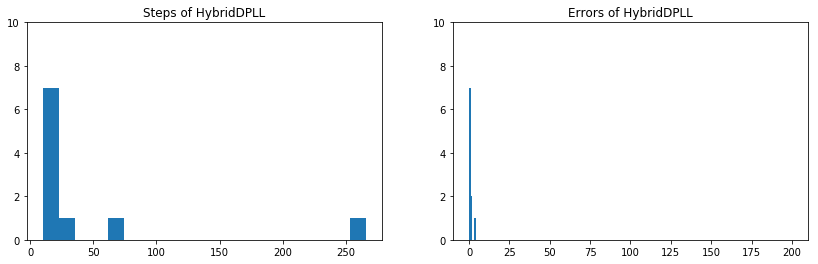

100%|██████████| 10/10 [00:09<00:00,  2.06it/s]


#Sats: 10; avg step: 46.50; stdev step: 82.25; avg error: 0.40; stdev error: 0.66


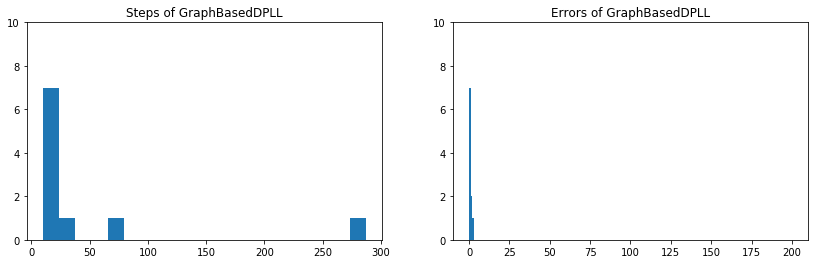

100%|██████████| 10/10 [00:00<00:00, 361.47it/s]


#Sats: 10; avg step: 68.20; stdev step: 42.88; avg error: 2.00; stdev error: 0.77


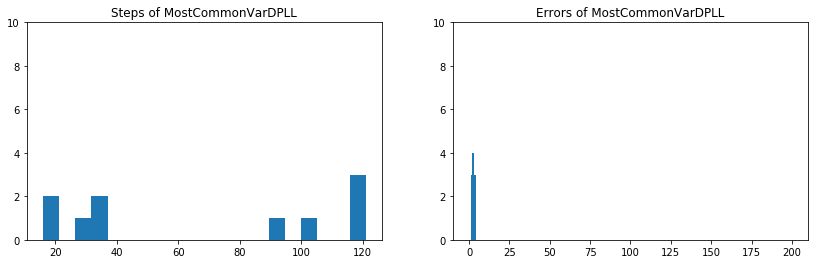

In [20]:
print_all(10, 200, 10)

100%|██████████| 10/10 [00:00<00:00, 58.62it/s]

We have generated 10 formulas
#Sats: 10; avg step: 199.00; stdev step: 101.61; avg error: 5.80; stdev error: 1.17


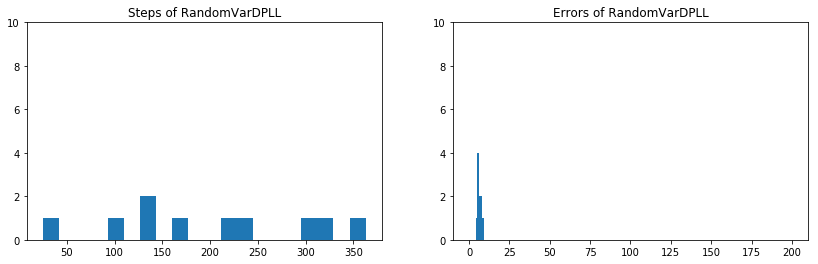

100%|██████████| 10/10 [00:00<00:00, 101.70it/s]


#Sats: 10; avg step: 130.10; stdev step: 79.45; avg error: 3.50; stdev error: 1.28


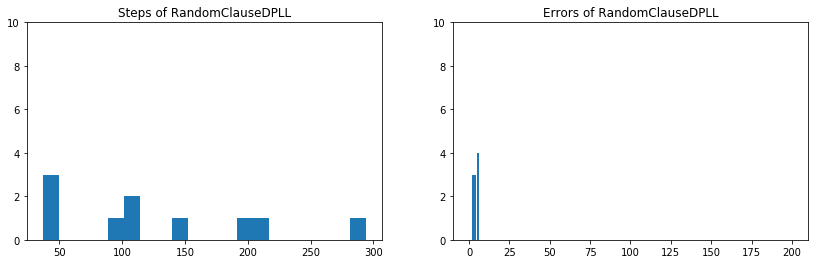

100%|██████████| 10/10 [00:13<00:00,  1.01s/it]


#Sats: 10; avg step: 109.60; stdev step: 149.11; avg error: 1.10; stdev error: 1.76


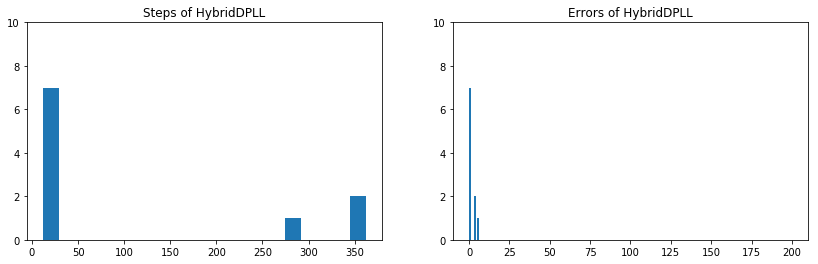

100%|██████████| 10/10 [00:26<00:00,  1.66s/it]


#Sats: 10; avg step: 141.50; stdev step: 206.90; avg error: 0.40; stdev error: 0.66


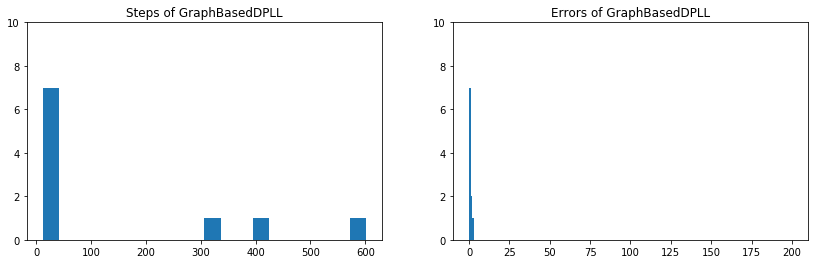

100%|██████████| 10/10 [00:00<00:00, 185.75it/s]


#Sats: 10; avg step: 74.10; stdev step: 56.11; avg error: 2.00; stdev error: 0.63


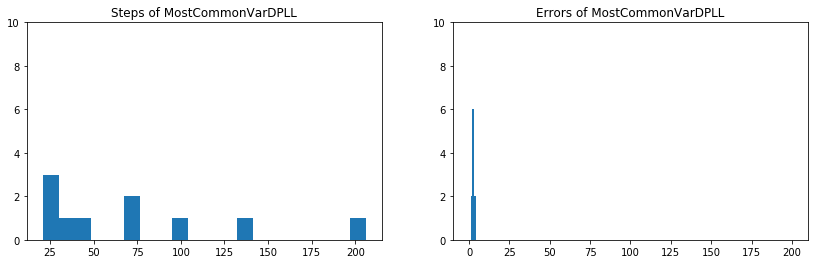

In [21]:
print_all(10, 200, 12)

 80%|████████  | 8/10 [00:00<00:00, 39.03it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 36.64it/s]


#Sats: 10; avg step: 554.30; stdev step: 374.21; avg error: 6.70; stdev error: 1.79


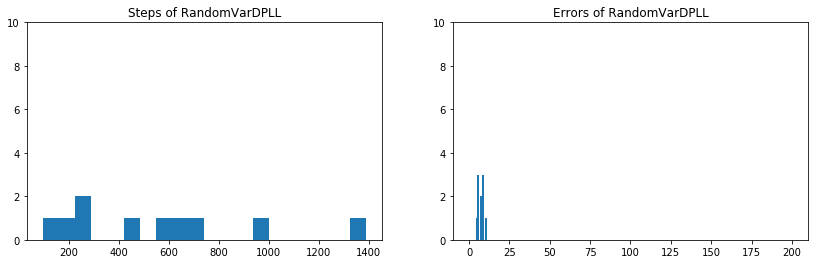

100%|██████████| 10/10 [00:00<00:00, 47.06it/s]


#Sats: 10; avg step: 363.70; stdev step: 161.82; avg error: 5.50; stdev error: 0.67


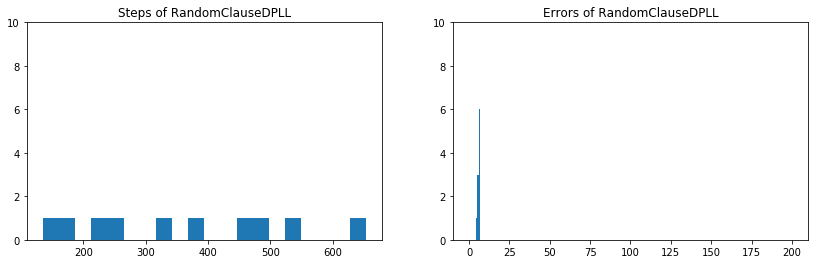

100%|██████████| 10/10 [00:09<00:00,  1.29it/s]


#Sats: 10; avg step: 46.00; stdev step: 84.56; avg error: 0.40; stdev error: 0.66


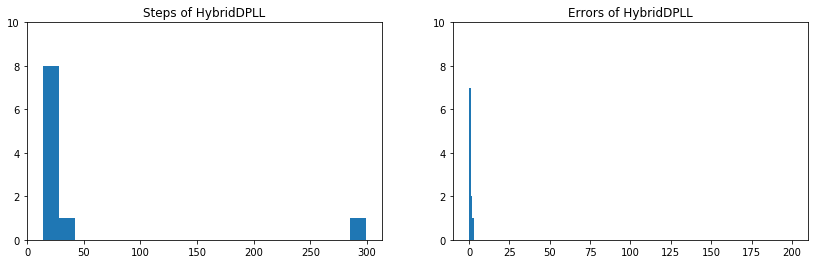

100%|██████████| 10/10 [00:11<00:00,  1.20it/s]


#Sats: 10; avg step: 43.10; stdev step: 75.89; avg error: 0.30; stdev error: 0.46


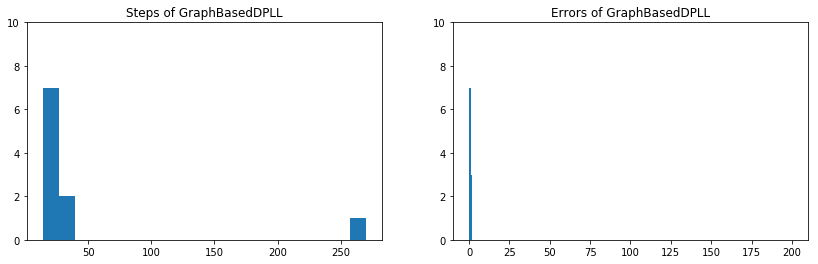

100%|██████████| 10/10 [00:00<00:00, 124.30it/s]


#Sats: 10; avg step: 100.20; stdev step: 103.76; avg error: 1.70; stdev error: 0.90


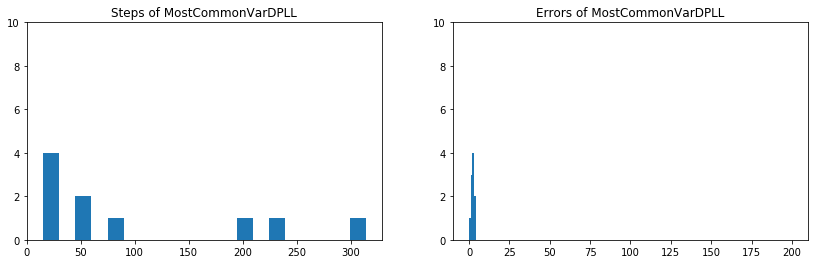

In [22]:
print_all(10, 200, 14)

 60%|██████    | 6/10 [00:00<00:00, 18.22it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 17.73it/s]


#Sats: 10; avg step: 1160.50; stdev step: 989.90; avg error: 7.10; stdev error: 1.76


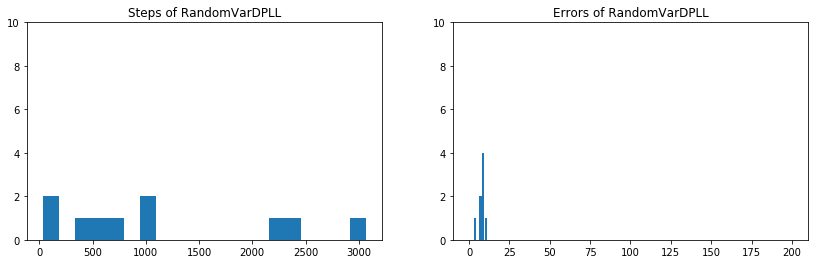

100%|██████████| 10/10 [00:00<00:00, 24.87it/s]


#Sats: 10; avg step: 738.70; stdev step: 508.69; avg error: 4.10; stdev error: 1.70


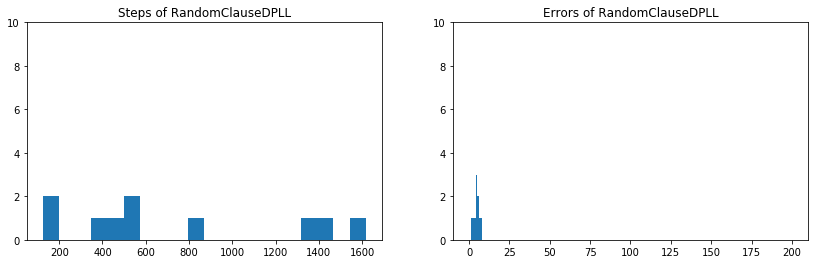

100%|██████████| 10/10 [00:12<00:00,  1.79s/it]


#Sats: 10; avg step: 79.70; stdev step: 157.81; avg error: 0.40; stdev error: 0.92


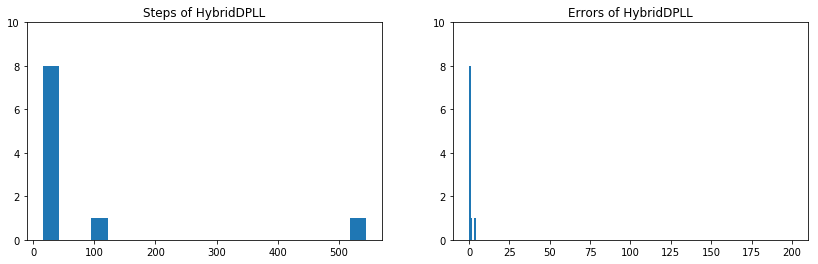

100%|██████████| 10/10 [00:21<00:00,  3.14s/it]


#Sats: 10; avg step: 93.70; stdev step: 199.17; avg error: 0.20; stdev error: 0.40


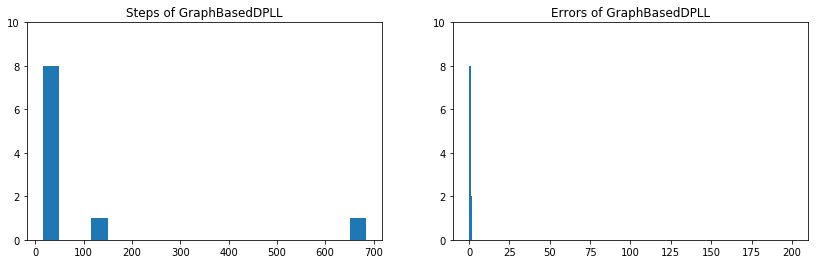

100%|██████████| 10/10 [00:00<00:00, 61.80it/s]


#Sats: 10; avg step: 222.30; stdev step: 244.23; avg error: 1.90; stdev error: 1.37


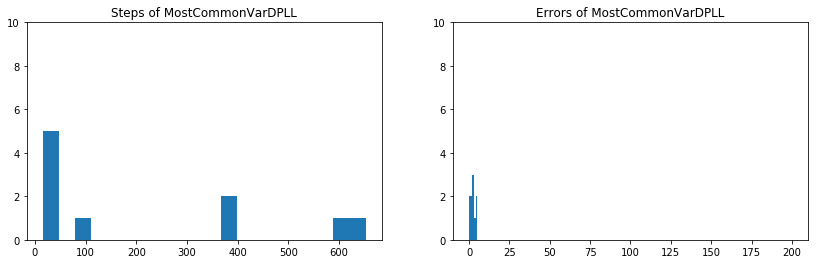

In [23]:
print_all(10, 200, 16)

 10%|█         | 1/10 [00:00<00:02,  4.30it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


#Sats: 10; avg step: 2956.50; stdev step: 1874.69; avg error: 8.80; stdev error: 1.72


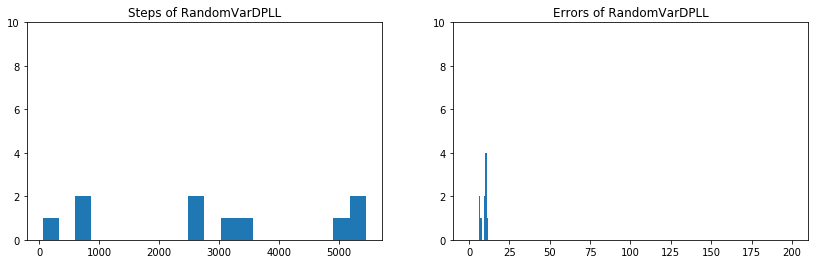

100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


#Sats: 10; avg step: 1864.80; stdev step: 1240.39; avg error: 6.20; stdev error: 2.36


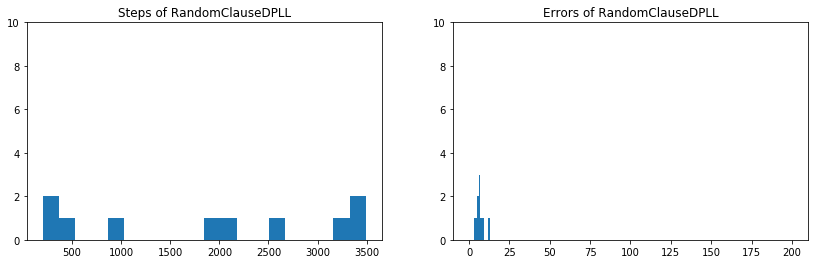

100%|██████████| 10/10 [00:27<00:00,  2.51s/it]


#Sats: 10; avg step: 824.00; stdev step: 760.43; avg error: 2.50; stdev error: 1.80


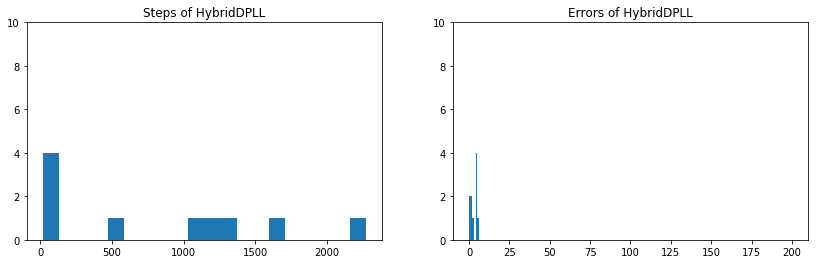

100%|██████████| 10/10 [05:34<00:00, 42.41s/it]


#Sats: 10; avg step: 1658.40; stdev step: 1931.98; avg error: 1.00; stdev error: 0.63


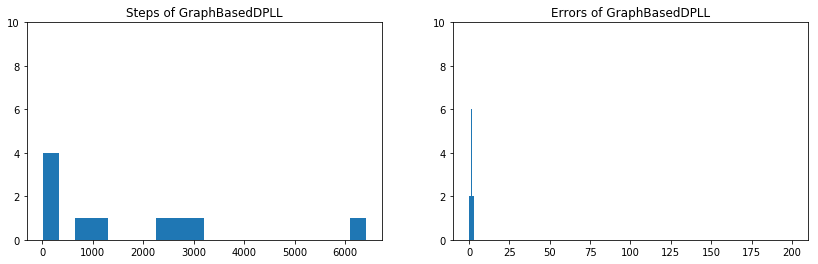

100%|██████████| 10/10 [00:00<00:00, 26.16it/s]


#Sats: 10; avg step: 536.20; stdev step: 309.31; avg error: 2.70; stdev error: 1.19


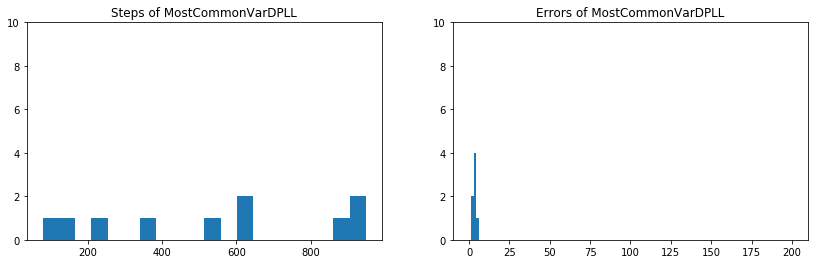

In [24]:
print_all(10, 200, 18)

 10%|█         | 1/10 [00:00<00:03,  2.58it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


#Sats: 10; avg step: 5836.10; stdev step: 3239.13; avg error: 9.30; stdev error: 2.49


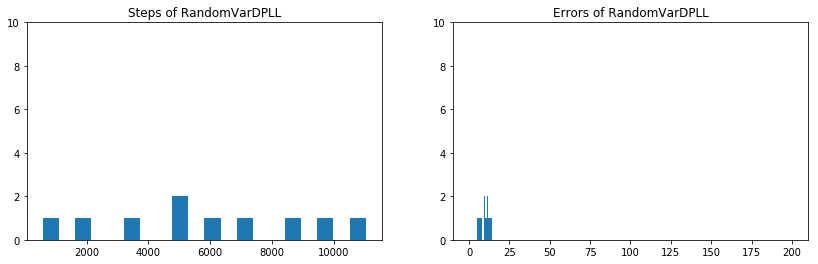

100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


#Sats: 10; avg step: 2371.10; stdev step: 1882.74; avg error: 5.60; stdev error: 2.33


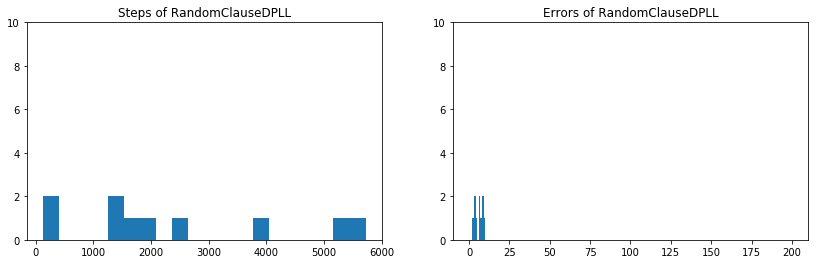

100%|██████████| 10/10 [00:21<00:00,  1.68s/it]


#Sats: 10; avg step: 222.80; stdev step: 282.79; avg error: 1.20; stdev error: 1.40


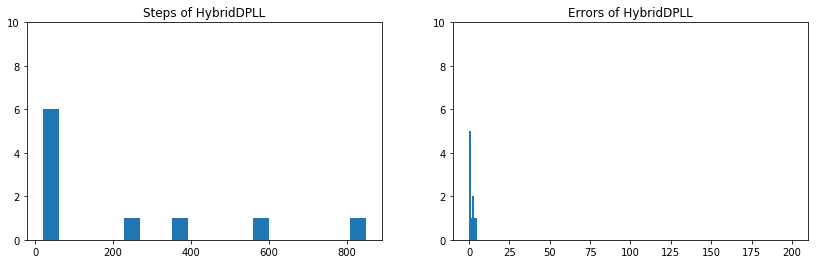

100%|██████████| 10/10 [01:33<00:00,  5.44s/it]


#Sats: 10; avg step: 455.20; stdev step: 725.87; avg error: 0.60; stdev error: 0.66


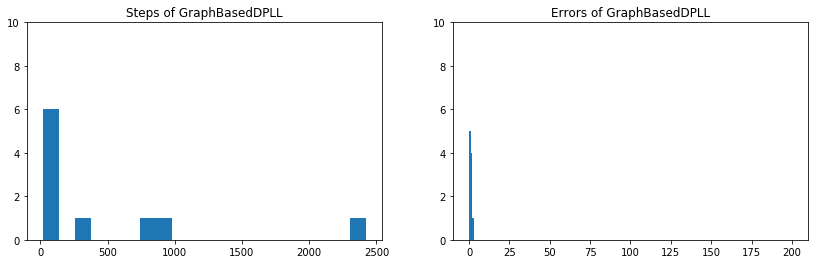

100%|██████████| 10/10 [00:00<00:00, 13.22it/s]


#Sats: 10; avg step: 945.60; stdev step: 728.79; avg error: 3.50; stdev error: 1.36


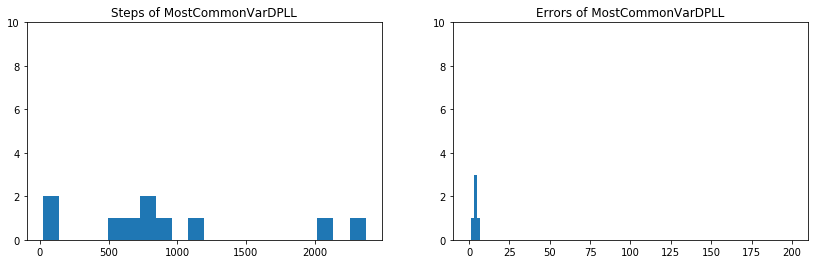

In [25]:
print_all(10, 200, 20)

 10%|█         | 1/10 [00:02<00:25,  2.89s/it]

We have generated 10 formulas


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


#Sats: 10; avg step: 29930.00; stdev step: 15179.63; avg error: 13.40; stdev error: 2.15


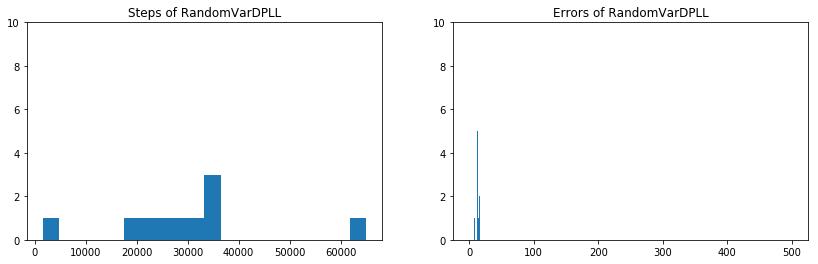

100%|██████████| 10/10 [00:04<00:00,  1.84it/s]


#Sats: 10; avg step: 7171.40; stdev step: 7316.74; avg error: 7.20; stdev error: 2.68


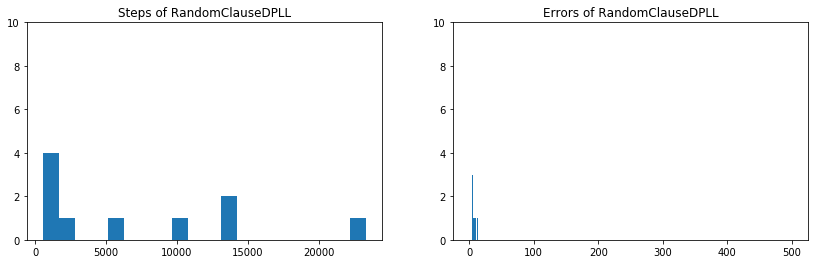

100%|██████████| 10/10 [00:34<00:00,  3.30s/it]


#Sats: 10; avg step: 1562.00; stdev step: 2391.36; avg error: 1.70; stdev error: 1.73


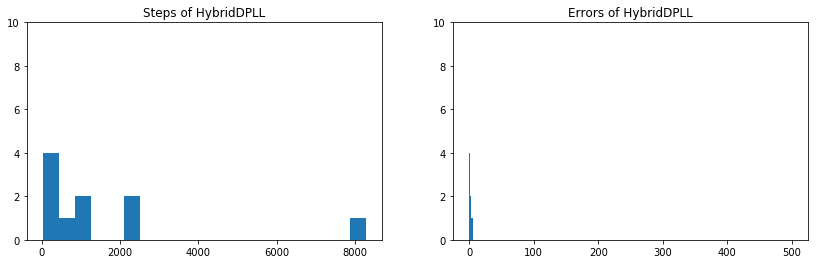

100%|██████████| 10/10 [22:57<00:00, 85.20s/it]


#Sats: 10; avg step: 5773.30; stdev step: 6893.55; avg error: 0.70; stdev error: 0.64


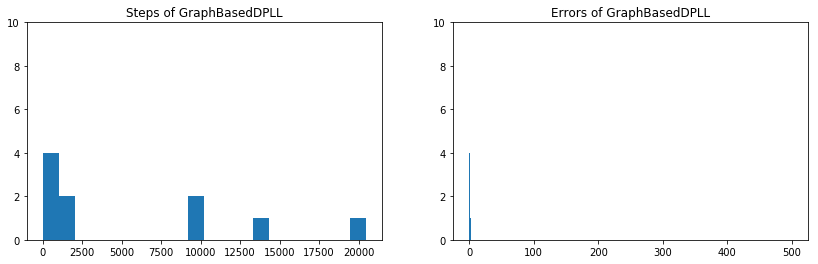

100%|██████████| 10/10 [00:04<00:00,  1.99it/s]


#Sats: 10; avg step: 4456.30; stdev step: 2583.99; avg error: 3.50; stdev error: 1.12


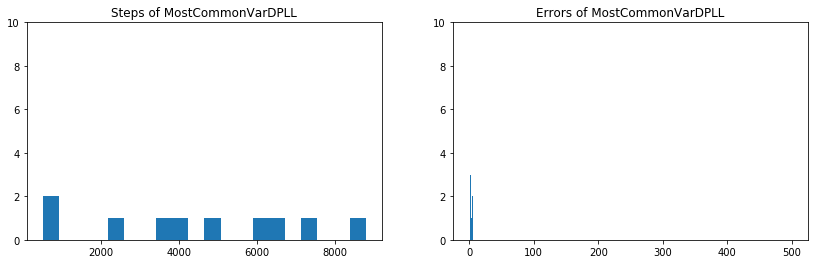

In [26]:
print_all(10, 500, 25)

 10%|█         | 1/10 [00:07<01:04,  7.17s/it]

We have generated 10 formulas


100%|██████████| 10/10 [01:51<00:00, 13.36s/it]


#Sats: 10; avg step: 146960.20; stdev step: 145743.01; avg error: 14.10; stdev error: 1.22


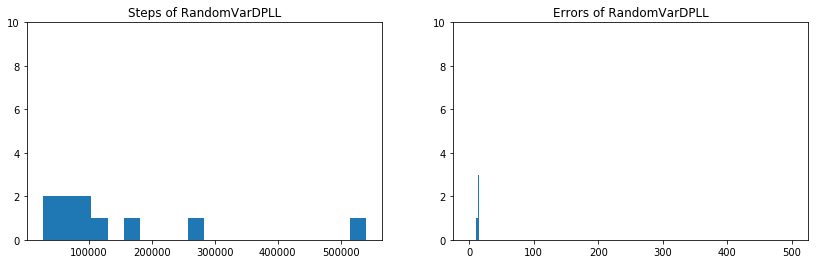

100%|██████████| 10/10 [00:59<00:00,  7.40s/it]


#Sats: 10; avg step: 66206.50; stdev step: 51386.48; avg error: 9.50; stdev error: 1.75


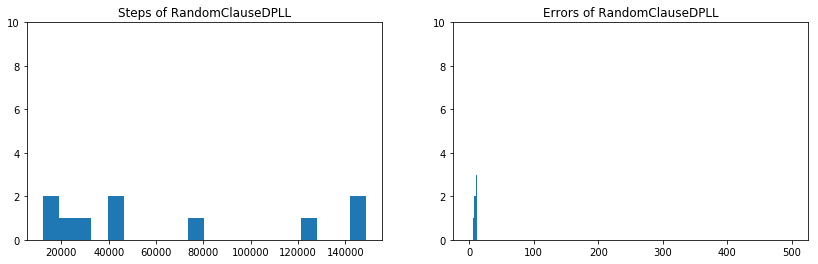

100%|██████████| 10/10 [00:58<00:00,  5.90s/it]


#Sats: 10; avg step: 12985.90; stdev step: 24707.54; avg error: 3.30; stdev error: 2.69


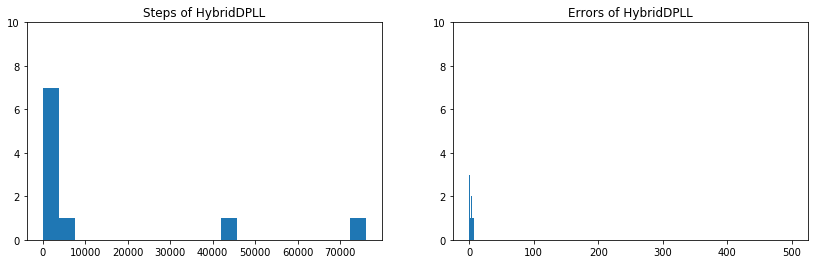

100%|██████████| 10/10 [00:12<00:00,  1.45s/it]


#Sats: 10; avg step: 10525.40; stdev step: 9126.77; avg error: 5.30; stdev error: 1.35


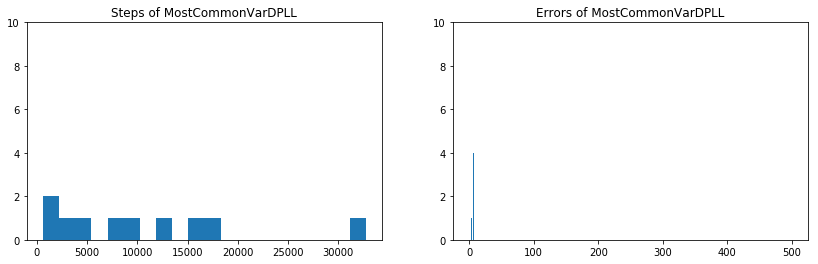

In [27]:
print_all(10, 500, 30, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [02:26<00:00, 14.26s/it]


#Sats: 10; avg step: 65522.50; stdev step: 120281.78; avg error: 3.80; stdev error: 2.52


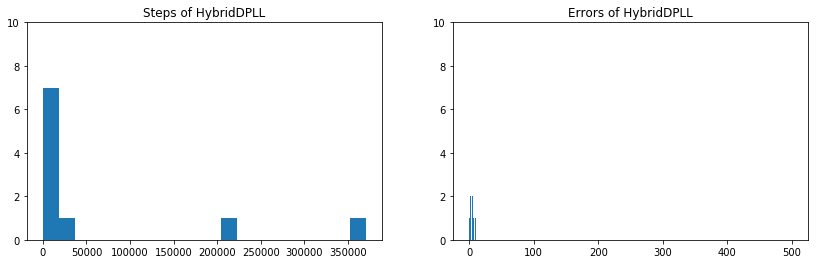

100%|██████████| 10/10 [03:45<00:00, 15.67s/it]


#Sats: 10; avg step: 175445.10; stdev step: 175014.97; avg error: 6.80; stdev error: 1.25


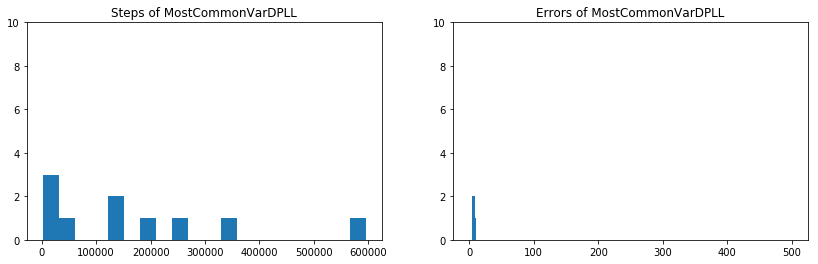

In [31]:
print_all(10, 500, 40, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [49:15<00:00, 323.38s/it]


#Sats: 10; avg step: 1893618.90; stdev step: 2694579.54; avg error: 6.50; stdev error: 2.50


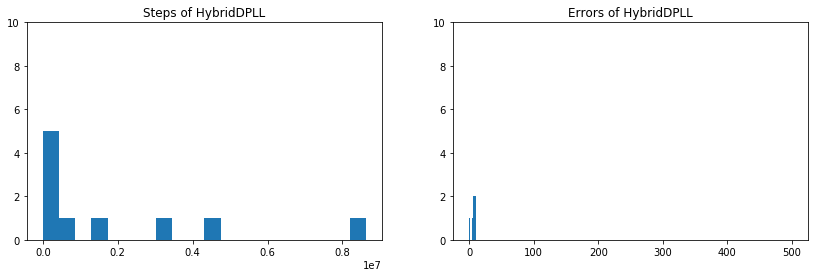

100%|██████████| 10/10 [1:41:30<00:00, 692.44s/it]


#Sats: 10; avg step: 3889018.80; stdev step: 2859777.81; avg error: 8.80; stdev error: 1.47


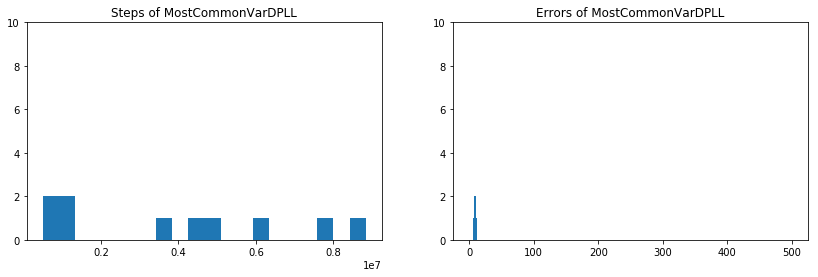

In [32]:
print_all(10, 500, 50, light=True)